# Manipulating Time Series
Notebook to follow along with final chapter of the DataCamp Manipulating Time Series course.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yfinance as yf

In [2]:
%matplotlib inline

In [3]:
def ddir(name=None):
    data_dir = 'dc_manipulating_time_series/stock_data/'
    if name is None:
        print(os.listdir(data_dir))
    else:
        return os.path.join(data_dir, name)

In [4]:
ddir()

['apple_google.csv', 'nasdaq_screener_1646066842549.csv', '5_stocks.csv', 'components.csv', 'stock_data.zip', 'djia2.csv', 'dow_jones.csv', 'msft_aapl.csv', 'market_cap_series.csv', 'listings.xlsx', 'tickers.csv', 'asset_classes.csv', 'djia.csv', 'stocks_4.csv', 'index.csv', 'unrate_2000.csv', 'debt_unemployment.csv', 'fb.csv', 'goog_fb.csv', 'sp500.csv', 'google.csv', 'unrate.csv', 'stock_data.csv', 'yahoo.csv', 'dc_correlation.xls', 'dc_stock_data.xlsx', 'gdp_growth.csv', 'random_walk.csv', 'nyse.csv']


## Import the data

In [5]:
nyse = pd.read_excel(ddir('listings.xlsx'), sheet_name='nyse', na_values='n/a')
nyse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stock Symbol           3147 non-null   object 
 1   Company Name           3147 non-null   object 
 2   Last Sale              3079 non-null   float64
 3   Market Capitalization  3147 non-null   float64
 4   IPO Year               1361 non-null   float64
 5   Sector                 2177 non-null   object 
 6   Industry               2177 non-null   object 
dtypes: float64(3), object(4)
memory usage: 172.2+ KB


/home/mattmcd/Work/Projects/PyBayes/venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
nyse.head()

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
0,DDD,3D Systems Corporation,14.48,1.647165e+09,NaN,Technology,Computer Software: Prepackaged Software
1,MMM,3M Company,188.65,1.127366e+11,NaN,Health Care,Medical/Dental Instruments
2,WBAI,500.com Limited,13.96,5.793129e+08,2013.0,Consumer Services,Services-Misc. Amusement & Recreation
3,WUBA,58.com Inc.,36.11,5.225238e+09,2013.0,Technology,"Computer Software: Programming, Data Processing"
4,AHC,A.H. Belo Corporation,6.20,1.347351e+08,NaN,Consumer Services,Newspapers/Magazines


In [7]:
nyse.loc[nyse['Stock Symbol'].isin(['CPRT', 'ILMN']), :]

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry


Problem: it looks like the listing data Excel file from the Datacamp data download for this course contains different stocks to the ones we want.  Some investigation shows that the 
[NASDAQ listings](https://www.nasdaq.com/market-activity/stocks/screener) do have all the stocks of interest.  
Some filtering by sector and removing stocks more recent than the ones used in the course, e.g. TSLA, is
then required to get the tickers of the biggest companies in each sector to match those expected in the course (and 
whose prices are available in the data files).

In [8]:
# NASDAQ listings from https://www.nasdaq.com/market-activity/stocks/screener 
# Looks like the listings data for the exercise is from Nasdaq rather than NYSE
nasdaq = pd.read_csv(ddir('nasdaq_screener_1646066842549.csv')).rename(
    columns={'Symbol': 'Stock Symbol', 'Market Cap': 'Market Capitalization', 'Name': 'Company Name'}
)
nasdaq['Last Sale'] = nasdaq['Last Sale'].replace({'\$': '', ',': ''}, regex=True).astype(float)
nasdaq.head()

,Stock Symbol,Company Name,Last Sale,Net Change,% Change,Market Capitalization,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,132.485,-1.245,-0.931%,3.979400e+10,United States,1999.0,351530,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,78.990,1.140,1.464%,1.464499e+10,NaN,2016.0,3394629,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,9.750,-0.010,-0.102%,1.218750e+09,NaN,2021.0,2630,Finance,Business Services
3,AACG,ATA Creativity Global American Depositary Shares,1.340,-0.020,-1.471%,4.204507e+07,China,NaN,13606,Miscellaneous,Service to the Health Industry
4,AACI,Armada Acquisition Corp. I Common Stock,9.790,-0.020,-0.204%,2.027460e+08,United States,2021.0,13003,NaN,NaN


In [9]:
nasdaq.set_index('Stock Symbol', inplace=True) # Make Stock Symbol the index
nasdaq.dropna(subset=['Sector'], inplace=True) # Remove stocks without sector info
nasdaq['Market Capitalization'] /= 1e6 # Scale to million $ 

In [10]:
# Exercise only considers stocks that IPOd before 2019, need to filter
# by this as well otherwise reading stock time series data fails 
# due to missing tickers.  Also fiddle with sector label to get things matching.
nasdaq = nasdaq.loc[(nasdaq['IPO Year'] < 2016), :]
nasdaq.loc['GS', 'Sector'] = 'Bank'
nasdaq.loc['ILMN', 'Sector'] = 'Biotech'
nasdaq.loc['CPRT', 'Sector'] = 'Finance'


In [11]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1595 entries, A to ZYNE
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           1595 non-null   object 
 1   Last Sale              1595 non-null   float64
 2   Net Change             1595 non-null   float64
 3   % Change               1595 non-null   object 
 4   Market Capitalization  1595 non-null   float64
 5   Country                1491 non-null   object 
 6   IPO Year               1595 non-null   float64
 7   Volume                 1595 non-null   int64  
 8   Sector                 1595 non-null   object 
 9   Industry               1595 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 201.6+ KB


In [12]:
# nasdaq.loc[nasdaq.index.isin(data.columns), :]

In [13]:
allowed_sectors = ['Technology', 'Health Care', 'Consumer Services', 'Miscellaneous',
 'Consumer Non-Durables', 'Bank', 'Health Care', 'Biotech', 'Energy', 'Basic Industries',
 'Public Utilities', 'Transportation']
disallowed_stocks = ['LIN', 'TSLA', 'GNRC', 'MPLX', 'HDB', 'ABBV', 'KMI', 'FANG', 'RSG',
                    'CLR', 'AWK', 'WES', 'PSXP']
components = nasdaq.loc[
    nasdaq.Sector.isin(allowed_sectors) & ~nasdaq.index.isin(disallowed_stocks), :
].groupby('Sector')['Market Capitalization'].nlargest(1)
components.sort_values(ascending=False)

Sector                 Stock Symbol
Technology             AAPL            2.862482e+06
Consumer Services      AMZN            1.570406e+06
Miscellaneous          MA              3.545385e+05
Transportation         UPS             1.810327e+05
Basic Industries       RIO             1.279028e+05
Health Care            AMGN            1.259611e+05
Bank                   GS              1.141503e+05
Consumer Non-Durables  EL              1.064988e+05
Biotech                ILMN            5.161532e+04
Public Utilities       TEF             2.699653e+04
Energy                 PAA             7.484558e+03
Name: Market Capitalization, dtype: float64

In [14]:
components.info()

<class 'pandas.core.series.Series'>
MultiIndex: 11 entries, ('Bank', 'GS') to ('Transportation', 'UPS')
Series name: Market Capitalization
Non-Null Count  Dtype  
--------------  -----  
11 non-null     float64
dtypes: float64(1)
memory usage: 1002.0+ bytes


In [15]:
# Index is MultiIndex so use get_level_values to extract tickers
tickers = components.index.get_level_values('Stock Symbol')
tickers

Index(['GS', 'RIO', 'ILMN', 'EL', 'AMZN', 'PAA', 'AMGN', 'MA', 'TEF', 'AAPL',
       'UPS'],
      dtype='object', name='Stock Symbol')

In [16]:
columns = ['Company Name', 'Market Capitalization', 'Last Sale']
component_info = nasdaq.loc[tickers, columns].sort_values('Market Capitalization', ascending=False)
pd.options.display.float_format = '{:,.2f}'.format
component_info

,Company Name,Market Capitalization,Last Sale
Stock Symbol,,,
AAPL,Apple Inc. Common Stock,"2,862,481.52",165.10
AMZN,Amazon.com Inc. Common Stock,"1,570,405.80","3,086.22"
MA,Mastercard Incorporated Common Stock,"354,538.52",362.71
UPS,United Parcel Service Inc. Common Stock,"181,032.71",207.99
RIO,Rio Tinto Plc Common Stock,"127,902.75",78.98
AMGN,Amgen Inc. Common Stock,"125,961.05",226.13
GS,Goldman Sachs Group Inc. (The) Common Stock,"114,150.30",342.20
EL,Estee Lauder Companies Inc. (The) Common Stock,"106,498.85",296.93
ILMN,Illumina Inc. Common Stock,"51,615.32",328.76


In [17]:
# Read the price time series data 
data = pd.read_csv(
    ddir('stock_data.csv'), parse_dates=['Date'], index_col='Date'
).loc[:, tickers.tolist()].dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GS      1761 non-null   float64
 1   RIO     1761 non-null   float64
 2   ILMN    1761 non-null   float64
 3   EL      1761 non-null   float64
 4   AMZN    1761 non-null   float64
 5   PAA     1761 non-null   float64
 6   AMGN    1761 non-null   float64
 7   MA      1761 non-null   float64
 8   TEF     1761 non-null   float64
 9   AAPL    1761 non-null   float64
 10  UPS     1761 non-null   float64
dtypes: float64(11)
memory usage: 165.1 KB


In [18]:
# Look at price returns over period
price_return = data.iloc[-1].div(data.iloc[0]).sub(1).mul(100).sort_values(ascending=False)
price_return

AMZN   460.02
ILMN   319.12
MA     302.06
AAPL   278.87
EL     215.16
AMGN   153.31
UPS     97.04
GS      38.35
PAA     19.59
RIO    -31.36
TEF    -67.78
dtype: float64

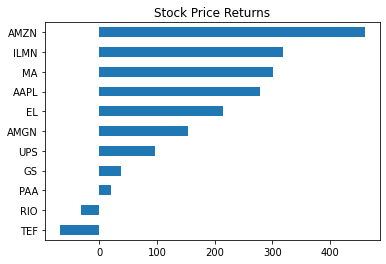

In [19]:
price_return.sort_values().plot(title='Stock Price Returns', kind='barh')
plt.show()

## Build a Market Cap Weighted Index

In [20]:
shares = component_info['Market Capitalization'].div(component_info['Last Sale'])
shares.sort_values(ascending=False)

Stock Symbol
AAPL   17,337.34
TEF     5,701.49
RIO     1,619.43
MA        977.48
UPS       870.39
PAA       711.12
AMGN      557.03
AMZN      508.84
EL        358.67
GS        333.58
ILMN      157.00
dtype: float64

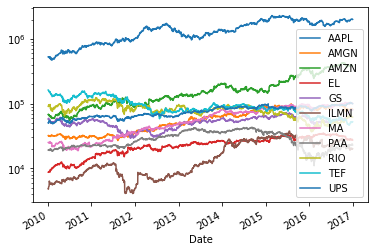

In [21]:
market_cap_series = data.mul(shares)
_ = market_cap_series.plot(logy=True)

In [22]:
# market_cap_series.first('D').append(market_cap_series.last('D'))  # .append is deprecated
pd.concat([market_cap_series.first('D'), market_cap_series.last('D')], axis=0)

,AAPL,AMGN,AMZN,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,
2010-01-04,"530,002.48","32,151.74","68,134.27","8,704.84","57,735.63","4,796.35","25,101.59","19,200.29","90,736.79","162,777.41","50,639.37"
2016-12-30,"2,008,010.72","81,443.26","381,567.16","27,434.40","79,875.19","20,102.28","100,924.44","22,962.13","62,283.36","52,453.67","99,781.67"


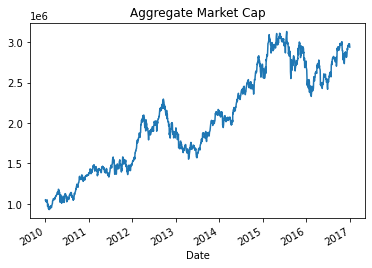

In [23]:
agg_mcap = market_cap_series.sum(axis=1)
_ = agg_mcap.plot(title='Aggregate Market Cap')

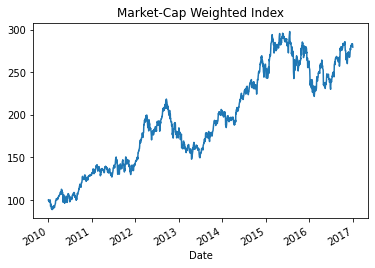

In [24]:
mcap_index = agg_mcap.div(agg_mcap.iloc[0]).mul(100)
_ = mcap_index.plot(title='Market-Cap Weighted Index')

## Evaluate Index Performance

In [25]:
# Total performance of companies in index
print(f'Companies in index added ${agg_mcap.iloc[-1] - agg_mcap.iloc[0]:,.2f}M in value')

Companies in index added $1,886,857.52M in value


In [26]:
change = pd.concat([market_cap_series.first('D'), market_cap_series.last('D')], axis=0)
change.diff().iloc[-1].sort_values()

TEF     -110,323.74
RIO      -28,453.42
PAA        3,761.83
ILMN      15,305.93
EL        18,729.57
GS        22,139.55
UPS       49,142.30
AMGN      49,291.53
MA        75,822.85
AMZN     313,432.89
AAPL   1,478,008.24
Name: 2016-12-30 00:00:00, dtype: float64

In [27]:
weights = component_info['Market Capitalization'].div(component_info['Market Capitalization'].sum())
weights

Stock Symbol
AAPL   0.52
AMZN   0.28
MA     0.06
UPS    0.03
RIO    0.02
AMGN   0.02
GS     0.02
EL     0.02
ILMN   0.01
TEF    0.00
PAA    0.00
Name: Market Capitalization, dtype: float64

In [28]:
index_return = (mcap_index.iloc[-1]/mcap_index.iloc[0] - 1)*100
index_return

179.70400981479017

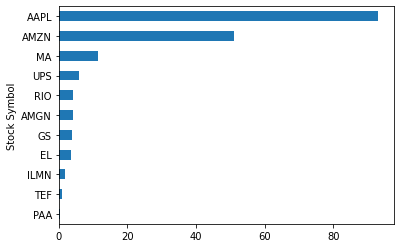

In [29]:
weighted_return = weights.mul(index_return)
_ = weighted_return.sort_values().plot(kind='barh')

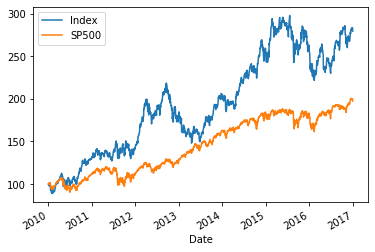

In [30]:
df_index = mcap_index.to_frame('Index')
df_index['SP500'] = pd.read_csv(ddir('sp500.csv'), parse_dates=['date'], index_col='date')
df_index['SP500'] = df_index['SP500'].div(df_index['SP500'].iloc[0]).mul(100)
_ = df_index.plot()

In [31]:
# Multi period returns
def multi_period_returns(r):
    return (np.prod(1 + r) - 1) * 100

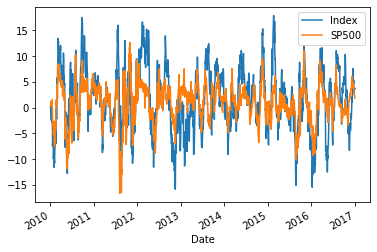

In [32]:
_ = df_index.pct_change().rolling('30D').apply(multi_period_returns).plot()

## Index Correlation and Exporting to Excel

In [33]:
daily_returns = data.pct_change().dropna()
correlations = daily_returns.corr()
correlations

,GS,RIO,ILMN,EL,AMZN,PAA,AMGN,MA,TEF,AAPL,UPS
GS,1.00,0.53,0.27,0.36,0.33,0.27,0.39,0.47,0.50,0.34,0.51
RIO,0.53,1.00,0.23,0.41,0.32,0.34,0.31,0.44,0.56,0.36,0.51
ILMN,0.27,0.23,1.00,0.21,0.24,0.16,0.34,0.30,0.23,0.26,0.27
EL,0.36,0.41,0.21,1.00,0.33,0.21,0.35,0.43,0.43,0.31,0.46
AMZN,0.33,0.32,0.24,0.33,1.00,0.18,0.32,0.43,0.33,0.33,0.38
PAA,0.27,0.34,0.16,0.21,0.18,1.00,0.23,0.24,0.25,0.21,0.22
AMGN,0.39,0.31,0.34,0.35,0.32,0.23,1.00,0.40,0.37,0.29,0.43
MA,0.47,0.44,0.30,0.43,0.43,0.24,0.40,1.00,0.45,0.39,0.49
TEF,0.50,0.56,0.23,0.43,0.33,0.25,0.37,0.45,1.00,0.33,0.52
AAPL,0.34,0.36,0.26,0.31,0.33,0.21,0.29,0.39,0.33,1.00,0.37


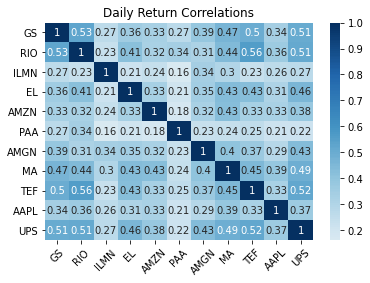

In [34]:
_ = sns.heatmap(correlations, annot=True, cmap='RdBu', center=0)
_ = plt.xticks(rotation=45)
_ = plt.title('Daily Return Correlations')

In [35]:
# correlations.to_excel(excel_writer=ddir('dc_correlation.xls'), sheet_name='correlations', startrow=1, startcol=1)

In [36]:
with pd.ExcelWriter(ddir('dc_stock_data.xlsx')) as writer:
    correlations.to_excel(excel_writer=writer, sheet_name='correlations')
    data.to_excel(excel_writer=writer, sheet_name='prices')
    data.pct_change().to_excel(excel_writer=writer, sheet_name='returns')

# Time Series Analysis
Second course in Skill Track - look at AR, MA, ACF etc

In [70]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima_model import ARMA

In [38]:
daily_returns.head()

,GS,RIO,ILMN,EL,AMZN,PAA,AMGN,MA,TEF,AAPL,UPS
Date,,,,,,,,,,,
2010-01-05,0.02,0.02,-0.01,-0.00,0.01,0.01,-0.01,-0.00,-0.00,0.00,0.00
2010-01-06,-0.01,0.03,0.06,0.00,-0.02,-0.00,-0.01,-0.00,-0.01,-0.02,-0.01
2010-01-07,0.02,0.00,0.02,0.01,-0.02,-0.01,-0.01,-0.01,-0.02,-0.00,-0.01
2010-01-08,-0.02,0.01,0.01,0.00,0.03,0.00,0.01,0.00,-0.01,0.01,0.05
2010-01-11,-0.02,-0.01,0.02,0.01,-0.02,-0.00,0.00,-0.02,-0.02,-0.01,0.04


In [39]:
len(daily_returns)

1760

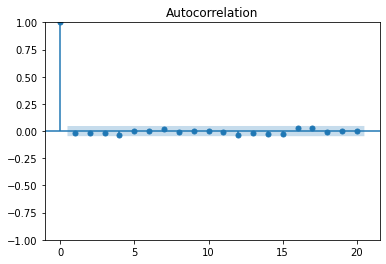

In [40]:
_ = plot_acf(daily_returns.AMZN, lags=20, alpha=0.05)

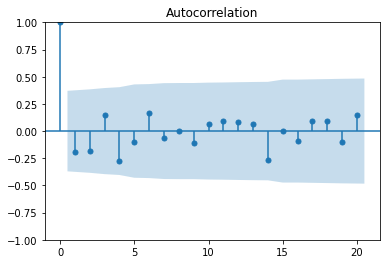

In [41]:
_ = plot_acf((1+daily_returns).resample('Q').prod().AMZN -1 , lags=20, alpha=0.05)

In [42]:
quarterly_returns = data.resample('Q').last().pct_change().dropna()
quarterly_returns.head()

,GS,RIO,ILMN,EL,AMZN,PAA,AMGN,MA,TEF,AAPL,UPS
Date,,,,,,,,,,,
2010-06-30,-0.23,-0.26,0.12,-0.14,-0.20,0.03,-0.12,-0.21,-0.22,0.07,-0.12
2010-09-30,0.10,0.35,0.13,0.13,0.44,0.07,0.05,0.12,0.34,0.13,0.17
2010-12-31,0.16,0.22,0.29,0.28,0.15,-0.00,-0.00,0.00,-0.08,0.14,0.09
2011-03-31,-0.06,-0.01,0.11,0.19,0.00,0.01,-0.03,0.12,0.11,0.08,0.02
2011-06-30,-0.16,0.02,0.07,0.09,0.14,0.00,0.09,0.20,-0.03,-0.04,-0.02


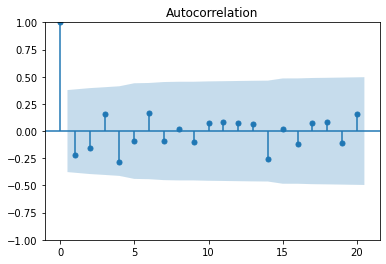

In [43]:
_ = plot_acf(quarterly_returns.AMZN, lags=20, alpha=0.05)

In [44]:
((1 + daily_returns).resample('Q').prod() - 1).head()

,GS,RIO,ILMN,EL,AMZN,PAA,AMGN,MA,TEF,AAPL,UPS
Date,,,,,,,,,,,
2010-03-31,-0.01,0.06,0.27,0.34,0.01,0.05,0.04,-0.01,-0.17,0.10,0.11
2010-06-30,-0.23,-0.26,0.12,-0.14,-0.20,0.03,-0.12,-0.21,-0.22,0.07,-0.12
2010-09-30,0.10,0.35,0.13,0.13,0.44,0.07,0.05,0.12,0.34,0.13,0.17
2010-12-31,0.16,0.22,0.29,0.28,0.15,-0.00,-0.00,0.00,-0.08,0.14,0.09
2011-03-31,-0.06,-0.01,0.11,0.19,0.00,0.01,-0.03,0.12,0.11,0.08,0.02


In [45]:
# aapl = yf.Ticker('aapl')

In [46]:
# aapl_historical = aapl.history(start="2022-03-01", end="2022-03-05", interval="1m")

In [52]:
# aapl_historical.to_csv(ddir('aapl_data_20220301.csv'))

In [56]:
aapl_historical = pd.read_csv(ddir('aapl_data_20220301.csv'), parse_dates=['Datetime'], index_col='Datetime')

In [57]:
aapl_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-03-01 09:30:00-05:00,164.70,165.30,164.56,165.15,2453049,0,0
2022-03-01 09:31:00-05:00,165.17,165.80,165.15,165.55,598722,0,0
2022-03-01 09:32:00-05:00,165.56,165.68,165.28,165.66,482473,0,0
2022-03-01 09:33:00-05:00,165.67,165.69,165.30,165.46,350441,0,0
2022-03-01 09:34:00-05:00,165.48,165.80,165.39,165.79,532744,0,0


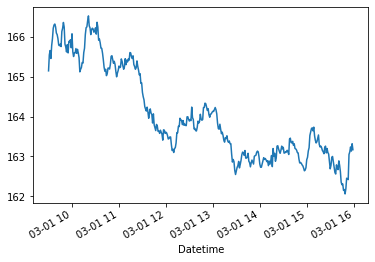

In [58]:
_ = aapl_historical.loc['2022-03-01', 'Close'].plot()

In [60]:
appl_ret_20220301 = aapl_historical.loc['2022-03-01', 'Close'].pct_change().dropna()
appl_ret_20220301.head()

Datetime
2022-03-01 09:31:00-05:00    0.00
2022-03-01 09:32:00-05:00    0.00
2022-03-01 09:33:00-05:00   -0.00
2022-03-01 09:34:00-05:00    0.00
2022-03-01 09:35:00-05:00    0.00
Name: Close, dtype: float64

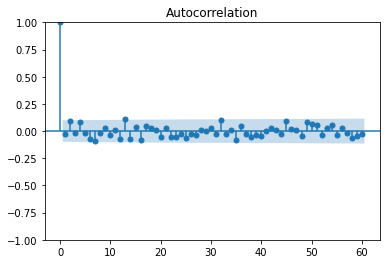

In [63]:
_ = plot_acf(appl_ret_20220301, lags=60)

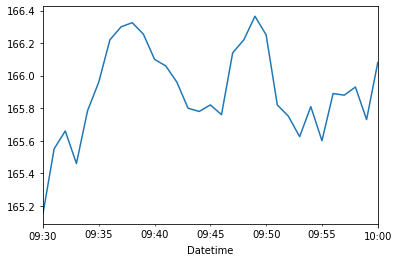

In [66]:
_ = aapl_historical.loc['2022-03-01 9:30':'2022-03-01 10:00', 'Close'].plot()

In [76]:
help(coint) #(data.AAPL, data.AMZN)

Help on function coint in module statsmodels.tsa.stattools:

coint(y0, y1, trend='c', method='aeg', maxlag=None, autolag: 'str | None' = 'aic', return_results=None)
    Test for no-cointegration of a univariate equation.
    
    The null hypothesis is no cointegration. Variables in y0 and y1 are
    assumed to be integrated of order 1, I(1).
    
    This uses the augmented Engle-Granger two-step cointegration test.
    Constant or trend is included in 1st stage regression, i.e. in
    cointegrating equation.
    
    **Warning:** The autolag default has changed compared to statsmodels 0.8.
    In 0.8 autolag was always None, no the keyword is used and defaults to
    "aic". Use `autolag=None` to avoid the lag search.
    
    Parameters
    ----------
    y0 : array_like
        The first element in cointegrated system. Must be 1-d.
    y1 : array_like
        The remaining elements in cointegrated system.
    trend : str {"c", "ct"}
        The trend term included in regression for 